## 패키지 불러오기 및 주요 변수 설정하기

In [ ]:
# 한글 폰트(나눔) 설치하기, 런타임 재시작 할 것
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [ ]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy import stats, optimize 
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', family='NanumBarunGothic')

In [ ]:
asset_ls = ['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']

In [ ]:
# 공분산 행렬
cov_mat = pd.DataFrame([[4.501, 3.335, 0.239, 0.413, 2.531, 3.333],
      [3.335, 3.409, 0.262, 0.464, 2.315, 3.429],
      [0.239, 0.262, 0.162, 0.166, -0.145, 0.339],
      [0.413, 0.464, 0.166, 0.232, -0.147, 0.553],
      [2.531, 2.315, -0.145, -0.147, 6.642, 2.732],
      [3.333, 3.429, 0.339, 0.553, 2.732, 4.442]],
      columns = asset_ls,
      index = asset_ls)/100
cov_mat

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
국내주식,0.0450,0.0333,0.0024,0.0041,0.0253,0.0333
해외주식,0.0333,0.0341,0.0026,0.0046,0.0232,0.0343
국내채권,0.0024,0.0026,0.0016,0.0017,-0.0014,0.0034
해외채권,0.0041,0.0046,0.0017,0.0023,-0.0015,0.0055
원자재,0.0253,0.0232,-0.0014,-0.0015,0.0664,0.0273
부동산,0.0333,0.0343,0.0034,0.0055,0.0273,0.0444


In [ ]:
# 비중행렬(각 주식의 기대수익, 최소비중, 최대비중, SAA 비중 포함)
weight_constraint = pd.DataFrame([[8.13, 9.36, 4.33, 3.87, 8.16, 9.01],
                        [5, 5, 5, 5, 5,5],
                        [50, 50, 50, 50, 50,50],
                       [20, 20, 20, 20, 10, 10]],
          columns = asset_ls,
          index = ['기대수익', '최소비중', '최대비중', '초기 비중'])/100
weight_constraint

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
기대수익,0.0813,0.0936,0.0433,0.0387,0.0816,0.0901
최소비중,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500
최대비중,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000
초기 비중,0.2000,0.2000,0.2000,0.2000,0.1000,0.1000


In [ ]:
# 무위험이자율, 기대수익률, 공분산행렬, 목표적자확률, 목표기대수익률을 설정(전역변수로 선언)
global risk_free_rate, expected_return, covariance_matrix, target_expected_return, target_std, target_min_return, target_shortfall_prob
risk_free_rate = 0.0348
expected_return = weight_constraint.loc['기대수익', :]
covariance_matrix = cov_mat.copy()
target_expected_return = 6.5/100
target_std = 20/100
target_min_return =  -5.0 /100
target_shortfall_prob = 0.20

In [ ]:
# 다양한 정보들을 확인할 수 있도록 열을 추가해주는 함수를 미리 작성
def add_columns(df):
  global risk_free_rate, expected_return, covariance_matrix, target_expected_return, target_min_return, target_shortfall_prob
  return_df, temp = df.copy(), df.copy()
  return_df['비중합'] = temp.apply(lambda x: sum(x), axis=1)
  return_df['기대수익'] = temp @ expected_return
  return_df['실효기대수익'] = return_df['기대수익'] - risk_free_rate
  return_df['표준편차'] = temp.apply(lambda x: calculate_portfolio_std(x, covariance_matrix), axis=1)
  return_df['샤프비율'] = return_df['실효기대수익'] / return_df['표준편차']
  return_df['Shortfall Risk'] = norm.cdf(return_df['기대수익'].sub(target_min_return).mul(-1).div(return_df['표준편차']))
  return_df['VAR'] = calculate_VAR(return_df['기대수익'], return_df['표준편차'])
  return_df['CVAR'] = calculate_CVAR(return_df['기대수익'], return_df['표준편차'])
  return return_df

## 임의의 포트폴리오 생성

In [ ]:
# 포트폴리오의 기대수익률 계산
def cacluate_expected_portfolio_return(weight, expected_return):
  expected_portfolio_return = sum(np.array(weight) * np.array(expected_return))
  return expected_portfolio_return

# 포트폴리오의 표준편차 계산
def calculate_portfolio_std(weight, cov):
  portfolio_std = (np.array(weight)@ np.array(cov)@ np.array(weight)) ** 0.5
  return portfolio_std

# 샤프비율 계산
def calculate_sharpe_ratio(expected_return, risk_free_rate, std):
  return (expected_return - risk_free_rate) / std
  
# 적자확률 계산
def calculate_portfolio_shortfall_prob(target_min_return, std, ert):
  rv = stats.norm()
  shortfall_prob = rv.cdf((target_min_return-ert)/std)
  return shortfall_prob

# VAR 계산
def calculate_VAR(ert, std, prob=0.05):
  return norm.ppf(prob, ert, std)

# CVAR 계산
def calculate_CVAR(ert, std, prob=0.05):
  CVAR = ert- std * norm.pdf(norm.ppf(1-prob))/prob
  return CVAR

In [ ]:
# 최소비중, 최대비중과 조건을 만족하는 50000개의 포트폴리오를 생성
import random
N = 50000
weight_ls = [0 for _ in range(N)]
assets = weight_constraint.columns
minimum = weight_constraint.loc['최소비중', :]
maximum = weight_constraint.loc['최대비중', :]
i = 0
while i < 50000:
  temp_weight = [0 for _ in range(len(assets))]
  for j in range(len(assets)-1):
    temp_weight[j] = random.uniform(minimum[j], maximum[j])
  temp_weight[-1] = 1- sum(temp_weight)
  if minimum[-1] <= temp_weight[-1] <= maximum[-1]:
    weight_ls[i] = temp_weight
    i += 1

In [ ]:
random_weights_df = pd.DataFrame(weight_ls, columns=asset_ls)
random_weights_df = add_columns(random_weights_df)
random_weights_df.head(10)

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
0,0.1809,0.0901,0.2556,0.0748,0.3068,0.0918,1.0000,0.0704,0.0356,0.1319,0.2699,0.1807,-0.1466,-0.2017
1,0.1112,0.2285,0.2548,0.0680,0.2291,0.1084,1.0000,0.0726,0.0378,0.1284,0.2940,0.1699,-0.1386,-0.1923
2,0.2334,0.1197,0.3654,0.0973,0.1197,0.0645,1.0000,0.0653,0.0305,0.1064,0.2870,0.1393,-0.1097,-0.1542
3,0.1150,0.2637,0.1125,0.1707,0.1537,0.1845,1.0000,0.0747,0.0399,0.1358,0.2935,0.1793,-0.1487,-0.2055
4,0.0850,0.2230,0.1500,0.1526,0.1553,0.2340,1.0000,0.0739,0.0391,0.1334,0.2934,0.1765,-0.1455,-0.2013
5,0.0824,0.4753,0.1280,0.1426,0.0559,0.1157,1.0000,0.0772,0.0424,0.1383,0.3070,0.1787,-0.1502,-0.2080
6,0.0975,0.2581,0.0517,0.3558,0.1822,0.0546,1.0000,0.0679,0.0331,0.1152,0.2873,0.1530,-0.1216,-0.1697
7,0.0703,0.3137,0.0805,0.2050,0.0805,0.2501,1.0000,0.0756,0.0408,0.1380,0.2957,0.1813,-0.1514,-0.2090
8,0.2452,0.2743,0.0527,0.0924,0.0739,0.2616,1.0000,0.0811,0.0463,0.1619,0.2858,0.2090,-0.1852,-0.2528
9,0.4704,0.1461,0.0798,0.0799,0.0626,0.1612,1.0000,0.0781,0.0433,0.1635,0.2649,0.2167,-0.1908,-0.2591


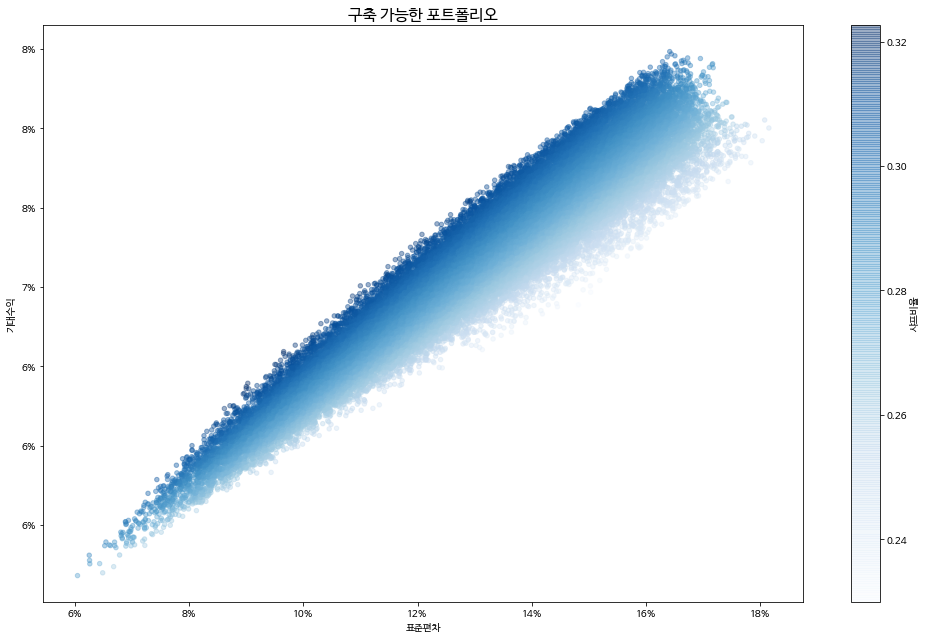

In [ ]:
fig, ax = plt.subplots()
random_weights_df.plot.scatter(x='표준편차', y='기대수익', c=10, ax=ax, cmap='Blues',alpha=0.4, figsize=(14, 9), colorbar=True)
ax.set_title('구축 가능한 포트폴리오', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig.tight_layout()

## MVO(샤프비율 최대화)

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 샤프비율 계산하는 함수(최소화를 해야하므로 끝에 음수를 곱해줌)
def sharpe_ratio_for_optimization(weight):
  global risk_free_rate, expected_return, covariance_matrix
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return -(expected_portfolio_return - risk_free_rate) / portfolio_std

# 비중합을 계산해주는 함수(형식을 맞춰주기 위해서 넣음)
def weight_sum_optimization(weight):
  return sum(weight)-1

In [ ]:
# 비중합이 1이라는 제약 조건
MVO_constraint = [{'type':'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
# 샤프비율을 최대화 하는 포트폴리오
max_sharpe_portfolio = optimize.minimize(sharpe_ratio_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=MVO_constraint, options=options).x
max_sharpe_portfolio_df = pd.DataFrame(max_sharpe_portfolio).T
max_sharpe_portfolio_df.columns = asset_ls
max_sharpe_portfolio_df.index = ['MVO']

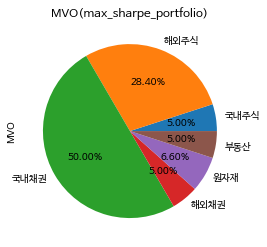

In [ ]:
max_sharpe_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='MVO(max_sharpe_portfolio)',
                                        autopct='%.2f%%')
plt.show()

In [ ]:
# 기대수익은 6.41%, 표준편차는 9.04%, 샤프비율이 32.45%
max_sharpe_portfolio_df = add_columns(max_sharpe_portfolio_df)
max_sharpe_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
MVO,0.0500,0.2840,0.5000,0.0500,0.0660,0.0500,1.0000,0.0641,0.0293,0.0904,0.3245,0.1033,-0.0845,-0.1223


## 리스크 패리티

In [ ]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [ ]:
# 리스크 패리티의 목적함수
# 만약 의도한 대로 위험기여도가 모두 같다면 목적함수의 값은 0이 된다.
def risk_parity_for_optimization(weight):
  global covariance_matrix
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - 1/len(risk_contribution))
  return sum_risk_diffs_squared

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건은 오직 자산의 비중 합이 1이라는 것 하나 뿐
def weight_sum_optimization(weights):
  return sum(weights)-1

In [ ]:
# 위와 마찬가지로 비중합이 1
RP_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
risk_parity_portfolio = optimize.minimize(risk_parity_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RP_constraint, options=options).x
risk_parity_portfolio_df = pd.DataFrame(risk_parity_portfolio).T
risk_parity_portfolio_df.columns = asset_ls
risk_parity_portfolio_df.index = ['RISK PARITY']

국내주식   0.1667
해외주식   0.1667
국내채권   0.1667
해외채권   0.1667
원자재    0.1667
부동산    0.1667
dtype: float64

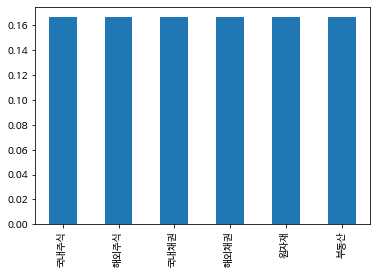

In [ ]:
# 각 자산이 위험 기여도가 1/n으로 동일
risk_contribution_check = calculate_risk_contribution(risk_parity_portfolio, cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar')
plt.show()

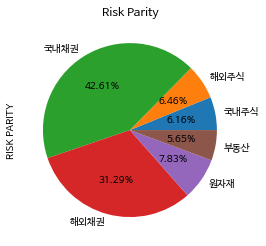

In [ ]:
risk_parity_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='Risk Parity',
                                       autopct='%.2f%%')
plt.show()

In [ ]:
risk_parity_portfolio_df = add_columns(risk_parity_portfolio_df)
risk_parity_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
RISK PARITY,0.0616,0.0646,0.4261,0.3129,0.0783,0.0565,1.0000,0.0531,0.0183,0.0640,0.2857,0.0537,-0.0522,-0.0790


## 벤치마크(동일가중 포트폴리오, 글로벌 최소분산 포트폴리오)

### 동일가중 포트폴리오

In [ ]:
# 동일한 비중으로 설정
equal_weight_portfolio = pd.DataFrame([1/len(cov_mat)] * len(cov_mat)).T
equal_weight_portfolio.columns = asset_ls
equal_weight_portfolio.index = ['EQUAL WEIGHT']

In [ ]:
equal_weight_portfolio = add_columns(equal_weight_portfolio)
equal_weight_portfolio

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
EQUAL WEIGHT,0.1667,0.1667,0.1667,0.1667,0.1667,0.1667,1.0000,0.0714,0.0366,0.1280,0.2861,0.1715,-0.1392,-0.1927


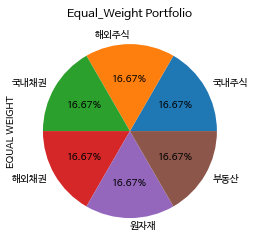

In [ ]:
equal_weight_portfolio.iloc[0,:6].plot(kind='pie',
                                title='Equal_Weight Portfolio',
                                autopct='%.2f%%')
plt.show()

### 최소분산 포트폴리오

In [ ]:
# 분산이 최소가 되도록 최적화
def GMV_for_optimization(weight):
  global covariance_matrix
  variance = np.array(weight).T @ covariance_matrix @ np.array(weight)
  return variance

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])
# 비중합이 1인 제약조건
GMV_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
GMV_portfolio = optimize.minimize(GMV_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=GMV_constraint, options=options).x
GMV_portfolio_df = pd.DataFrame(GMV_portfolio).T
GMV_portfolio_df.columns = asset_ls
GMV_portfolio_df.index = ['GMV']

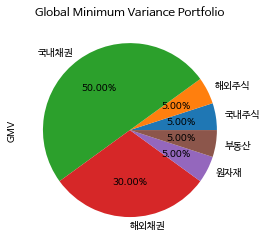

In [ ]:
GMV_portfolio_df.iloc[0,:6].plot(kind='pie',
                                title='Global Minimum Variance Portfolio',
                                autopct='%.2f%%')
plt.show()

In [ ]:
GMV_portfolio_df = add_columns(GMV_portfolio_df)
GMV_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
GMV,0.0500,0.0500,0.5000,0.3000,0.0500,0.0500,1.0000,0.0506,0.0158,0.0566,0.2790,0.0377,-0.0425,-0.0661


### 다른 방법론들의 위험배분 확인

In [ ]:
portfolios = [max_sharpe_portfolio_df, risk_parity_portfolio_df,GMV_portfolio_df, equal_weight_portfolio]
names = ['MVO', 'Risk Parity', 'GMV', 'Equal Weight']
df = pd.DataFrame()
for portfolio, name in zip(portfolios, names):
  rc = calculate_risk_contribution(portfolio.iloc[0,:6], cov_mat)
  df[name] = rc
df = df.T
df.head()

,국내주식,해외주식,국내채권,해외채권,원자재,부동산
MVO,0.1008,0.5610,0.1121,0.0162,0.1034,0.1065
Risk Parity,0.1667,0.1667,0.1667,0.1667,0.1667,0.1667
GMV,0.1449,0.1397,0.2584,0.2030,0.0928,0.1611
Equal Weight,0.2431,0.2239,0.0173,0.0285,0.2360,0.2512


국내주식   0.1008
해외주식   0.5610
국내채권   0.1121
해외채권   0.0162
원자재    0.1034
부동산    0.1065
dtype: float64

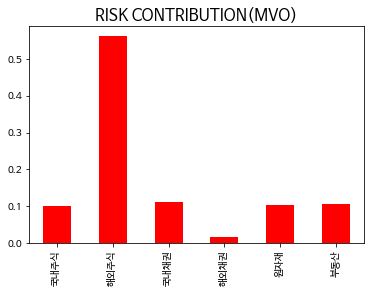

In [ ]:
# MVO
risk_contribution_check = calculate_risk_contribution(max_sharpe_portfolio_df.iloc[0,:6], cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar', color='red')
plt.title("RISK CONTRIBUTION(MVO)", fontsize=16)
plt.show()

국내주식   0.1449
해외주식   0.1397
국내채권   0.2584
해외채권   0.2030
원자재    0.0928
부동산    0.1611
dtype: float64

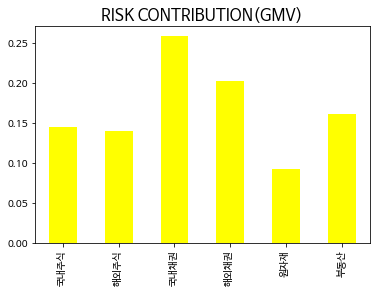

In [ ]:
# GMV
risk_contribution_check = calculate_risk_contribution(GMV_portfolio_df.iloc[0,:6], cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar', color='yellow')
plt.title("RISK CONTRIBUTION(GMV)", fontsize=16)
plt.show()

국내주식   0.2431
해외주식   0.2239
국내채권   0.0173
해외채권   0.0285
원자재    0.2360
부동산    0.2512
dtype: float64

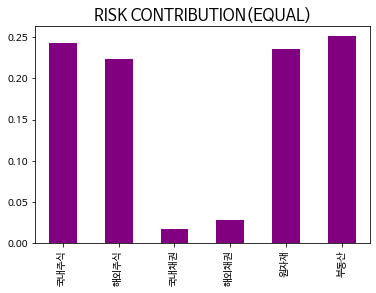

In [ ]:
# equal weight portfolio
risk_contribution_check = calculate_risk_contribution(equal_weight_portfolio.iloc[0,:6], cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar', color='purple')
plt.title("RISK CONTRIBUTION(EQUAL)", fontsize=16)
plt.show()

## 효율적 투자곡선과 함께 표시

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 샤프비율 계산하는 함수(최소화를 해야하므로 끝에 음수를 곱해줌)
def sharpe_ratio_for_optimization(weight):
  global risk_free_rate, expected_return, covariance_matrix
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return -(expected_portfolio_return - risk_free_rate) / portfolio_std

# 기대수익률을 계산하는 함수(0을 기준으로 등호가 쓰이므로 목표기대수익률을 뺀다)
def expected_return_for_optimization(weight):
  global expected_return, target_expected_return
  expected_portfolio_return = sum(np.array(weight) * np.array(expected_return))
  return expected_portfolio_return - target_expected_return

# 비중합을 계산해주는 함수(형식을 맞춰주기 위해서 넣음)
def weight_sum_optimization(weight):
  return sum(weight)-1

# 효율적 투자곡선을 그리기 위한 제약 조건
EF_constraints = [{'type':'eq', 'fun': weight_sum_optimization},
                {'type': 'eq', 'fun': expected_return_for_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

# 주어진 기대수익률 하에서 분산이 최소(샤프비율이 최대)가 되는 포트폴리오들을 찾아냄
efficient_frontier = []
for num in range(400, 852, 2):
  target_expected_return = num/10000
  result = optimize.minimize(sharpe_ratio_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=EF_constraints)['x']
  efficient_frontier.append(result)

In [ ]:
efficient_frontier = pd.DataFrame(efficient_frontier, columns=asset_ls,
                                  index=np.arange(0.0400, 0.0852, 0.0002))
efficient_frontier = add_columns(efficient_frontier)
efficient_frontier = efficient_frontier.set_index('표준편차')

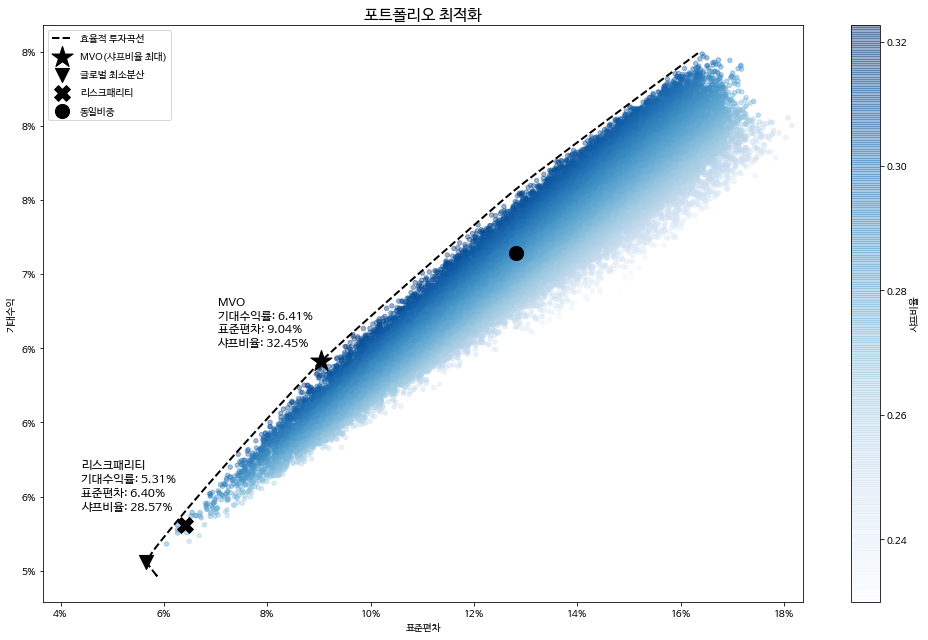

In [ ]:
fig, ax = plt.subplots()
random_weights_df.plot.scatter(x='표준편차', y='기대수익', c=10, ax=ax, cmap='Blues',alpha=0.4, figsize=(14, 9), colorbar=True)

efficient_frontier['기대수익'].plot(linestyle='--', lw=2, ax=ax, c='k', label='효율적 투자곡선')

r, sd, sharpe = float(max_sharpe_portfolio_df['기대수익']), float(max_sharpe_portfolio_df['표준편차']), float(max_sharpe_portfolio_df['샤프비율'])
ax.scatter(sd, r, marker='*', color='k', s=500, label='MVO(샤프비율 최대)')
desc = f"MVO\n기대수익률: {r*100:.2f}%\n표준편차: {sd*100:.2f}%\n샤프비율: {sharpe*100:.2f}%"
ax.text(sd-0.02, r+0.001, desc, fontsize=12)

r, sd = GMV_portfolio_df['기대수익'], GMV_portfolio_df['표준편차']
ax.scatter(sd, r, marker='v', color='k', s=200, label='글로벌 최소분산')

r, sd, sharpe = float(risk_parity_portfolio_df['기대수익']), float(risk_parity_portfolio_df['표준편차']), float(risk_parity_portfolio_df['샤프비율'])
ax.scatter(sd, r, marker='X', color='k', s=250, label='리스크패리티')
desc = f"리스크패리티\n기대수익률: {r*100:.2f}%\n표준편차: {sd*100:.2f}%\n샤프비율: {sharpe*100:.2f}%"
ax.text(sd-0.02, r+0.001, desc, fontsize=12)

r, sd = equal_weight_portfolio['기대수익'], equal_weight_portfolio['표준편차']
ax.scatter(sd, r, marker='o', color='k', s=200, label='동일비중')

ax.legend(labelspacing=0.8)
ax.set_xlim(min(efficient_frontier.index)-0.02, max(efficient_frontier.index)+.02)
ax.set_title('포트폴리오 최적화', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig.tight_layout()

## 추가적인 제약 조건

### MVO에 제약 조건 추가

Shortfall risk, 변동성 제약 조건 추가  
** Shortfall Risk: 설정한 용인 가능 최소 수익률 이하로 수익률이 떨어질 확률

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 샤프비율 계산하는 함수(최소화를 해야하므로 끝에 음수를 곱해줌)
def sharpe_ratio_for_optimization(weight):
  global risk_free_rate, expected_return, covariance_matrix
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return -(expected_portfolio_return - risk_free_rate) / portfolio_std

# 비중합을 계산해주는 함수(형식을 맞춰주기 위해서 넣음)
def weight_sum_optimization(weight):
  return sum(weight)-1

# 표준편차 조건
def std_for_optimization(weight):
  global covariance_matrix, target_std
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  return target_std - portfolio_std

# 적자확률 제약 조건
def shortfall_prob_for_optimization(weight):
  global expected_return, target_min_return, covariance_matrix, taret_shortfall_prob
  expected_portfolio_return = cacluate_expected_portfolio_return(weight, expected_return)
  portfolio_std = calculate_portfolio_std(weight, covariance_matrix)
  short_fall_prob = calculate_portfolio_shortfall_prob(target_min_return, portfolio_std, expected_portfolio_return)
  return target_shortfall_prob - short_fall_prob

# 제약 조건 설정(기대수익률, 표준편차, 적자확률 제약 하에서 샤프비율을 최대화)
options = {'ftol': 1e-20, 'maxiter': 5000}
constraints = [{'type':'eq', 'fun': weight_sum_optimization},
                    {'type': 'ineq', 'fun': std_for_optimization},
                {'type': 'ineq', 'fun': shortfall_prob_for_optimization}]

In [ ]:
MVO_constraints_df = optimize.minimize(sharpe_ratio_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=constraints, options=options).x
MVO_constraints_df = pd.DataFrame(MVO_constraints_df).T
MVO_constraints_df.columns = asset_ls
MVO_constraints_df.index = ["MVO"]

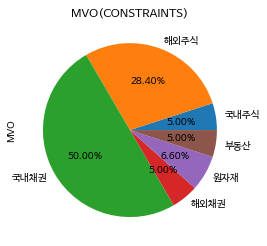

In [ ]:
MVO_constraints_df.iloc[0,:6].plot(kind='pie',
                                       title='MVO(CONSTRAINTS)',
                                        autopct='%.2f%%')

### 리스크 패리티(변동성 타겟팅)

변동성이 주어졌을 때, 그 것을 각각의 자산에 동일하게 배분하는 것을 목표로 함  
대부분의 경우, 목적이 이뤄지지는 않지만 목적함수의 값이 최소가 되도록 할 수 있음

In [ ]:
# target 변동성을 설정
global target_vol
target_vol = 6.9/100

In [ ]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [ ]:
# 리스크 패리티의 목적함수
# 만약 의도한 대로 위험기여도가 모두 같다면 목적함수의 값은 0이 된다.
def risk_parity_for_optimization(weight):
  global covariance_matrix
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - 1/len(risk_contribution))
  return sum_risk_diffs_squared

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건1 비중합은 1
def weight_sum_optimization(weights):
  return sum(weights)-1

# 제약조건2 포트폴리오의 변동성이 target 변동성과 동일
def target_vol_optimization(weights):
  global target_vol, covariance_matrix
  std = calculate_portfolio_std(weights, covariance_matrix)
  return (std - target_vol)

In [ ]:
# 두 가지 제약 조건 하에서 최적화를 진행
RP_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}, {'type': 'eq', 'fun': target_vol_optimization}]
options = {'ftol': 1e-20, 'maxiter': 50000}

In [ ]:
risk_parity_portfolio = optimize.minimize(risk_parity_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RP_constraint, options=options).x
risk_parity_portfolio_df = pd.DataFrame(risk_parity_portfolio).T
risk_parity_portfolio_df.columns = asset_ls
risk_parity_portfolio_df.index = ['RISK PARITY']

국내주식   0.1809
해외주식   0.1815
국내채권   0.1329
해외채권   0.1501
원자재    0.1711
부동산    0.1835
dtype: float64

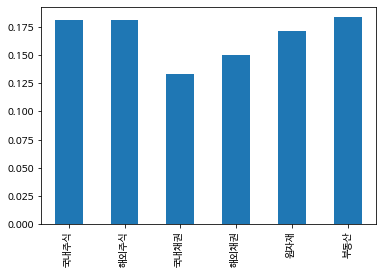

In [ ]:
# 각 자산이 위험 기여도를 확인
risk_contribution_check = calculate_risk_contribution(risk_parity_portfolio, cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar')
plt.show()

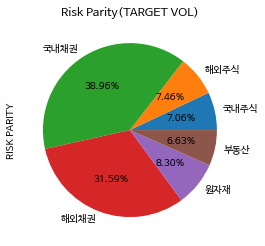

In [ ]:
risk_parity_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='Risk Parity(TARGET VOL)',
                                       autopct='%.2f%%')
plt.show()

In [ ]:
risk_parity_portfolio_df = add_columns(risk_parity_portfolio_df)
risk_parity_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
RISK PARITY,0.0706,0.0746,0.3896,0.3159,0.0830,0.0663,1.0000,0.0546,0.0198,0.0690,0.2864,0.0648,-0.0589,-0.0878


### 리스크 패리티(기대수익률 타겟팅)

기대수익률이 주어졌을 때, 그 것을 각각의 자산에 동일하게 배분하는 것을 목표로 함  
대부분의 경우, 목적이 이뤄지지는 않지만 목적함수의 값을 최소화하도록 할 수는 있음

In [ ]:
# target 변동성을 설정
global target_ret
target_ret = 5.4/100

In [ ]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [ ]:
# 리스크 패리티의 목적함수
# 만약 의도한 대로 위험기여도가 모두 같다면 목적함수의 값은 0이 된다.
def risk_parity_for_optimization(weight):
  global covariance_matrix
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - 1/len(risk_contribution))
  return sum_risk_diffs_squared

In [ ]:
# 시작점과 비중의 상하한선을 설정
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건1 비중합은 1
def weight_sum_optimization(weights):
  return sum(weights)-1

# 제약조건2 포트폴리오의 기대수익률이 target 기대수익률과 같음
def target_ret_optimization(weights):
  global target_ret, expected_return
  ret = cacluate_expected_portfolio_return(weights, expected_return)
  return (ret-target_ret)

In [ ]:
# 두 가지 제약 조건 하에서 최적화를 진행
RP_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}, {'type': 'eq', 'fun': target_ret_optimization}]
options = {'ftol': 1e-20, 'maxiter': 50000}

In [ ]:
risk_parity_portfolio = optimize.minimize(risk_parity_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RP_constraint, options=options).x
risk_parity_portfolio_df = pd.DataFrame(risk_parity_portfolio).T
risk_parity_portfolio_df.columns = asset_ls
risk_parity_portfolio_df.index = ['RISK PARITY']

국내주식   0.1732
해외주식   0.1782
국내채권   0.1528
해외채권   0.1496
원자재    0.1701
부동산    0.1761
dtype: float64

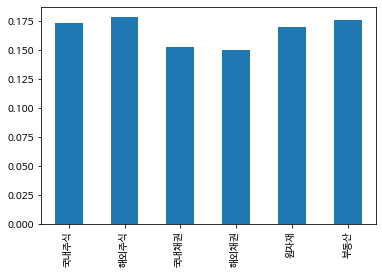

In [ ]:
# 각 자산이 위험 기여도를 확인
risk_contribution_check = calculate_risk_contribution(risk_parity_portfolio, cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar')
plt.show()

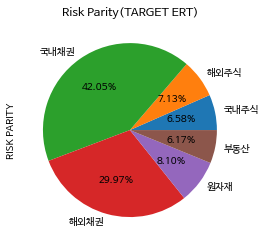

In [ ]:
risk_parity_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='Risk Parity(TARGET ERT)',
                                       autopct='%.2f%%')
plt.show()

In [ ]:
risk_parity_portfolio_df = add_columns(risk_parity_portfolio_df)
risk_parity_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
RISK PARITY,0.0658,0.0713,0.4205,0.2997,0.0810,0.0617,1.0000,0.0540,0.0192,0.0667,0.2880,0.0594,-0.0556,-0.0835


### 리스크 버젯팅

In [ ]:
global target_budget
target_budget = np.array([25, 25, 5, 5, 20, 20])/100
print("할당된 budget의 합이 1이 아닙니다") if sum(target_budget) != 1 else print("budget 설정 완료")
display(pd.DataFrame([target_budget], columns=['국내주식', '해외주식', '국내채권', '해외채권', '원자재', '부동산']))

budget 설정 완료


,국내주식,해외주식,국내채권,해외채권,원자재,부동산
0,0.2500,0.2500,0.0500,0.0500,0.2000,0.2000


In [ ]:
# 각 자산의 위험기여도를 출력하는 함수
# 각 자산의 비중과 공분산 행렬을 가지고, 각 자산에 대한 위험 기여도 산출 가능
def calculate_risk_contribution(weight, cov):
  variance = np.array(weight).T @ cov @ np.array(weight)
  sigma = sqrt(variance)
  mrc = 1/sigma * (cov @ weight)
  risk_contribution = weight * mrc
  risk_contirbution = risk_contribution/ risk_contribution.sum()
  return risk_contirbution

In [ ]:
# 리스크 버젯팅의 목적함수
# 만약 의도한 대로 위험기여도가 배분된다면 목적함수의 값은 0이 된다.
def risk_budgeting_for_optimization(weight):
  global covariance_matrix, target_budget
  risk_contribution = calculate_risk_contribution(weight, covariance_matrix)
  sum_risk_diffs_squared = 0
  for i in range(len(risk_contribution)):
      sum_risk_diffs_squared += np.square(risk_contribution[i] - target_budget[i])
  return sum_risk_diffs_squared

In [ ]:
# 시작점과 비중의 상하한선을 설정(비중 상하한선에 내에서 나오지 않으면 최적화는 실패)
Init_Point = tuple(weight_constraint.loc['초기 비중',:])
bnds = tuple([(min_weight, max_weight) for (min_weight,max_weight) in zip(weight_constraint.loc['최소비중', :], weight_constraint.loc['최대비중', :])])

# 제약조건은 오직 자산의 비중 합이 1이라는 것 하나 뿐
def weight_sum_optimization(weights):
  return sum(weights)-1

In [ ]:
# 위와 마찬가지로 비중합이 1
RB_constraint = [{'type': 'eq', 'fun': weight_sum_optimization}]
options = {'ftol': 1e-20, 'maxiter': 5000}

In [ ]:
risk_budgeting_portfolio = optimize.minimize(risk_budgeting_for_optimization, Init_Point, method='SLSQP', bounds=bnds, constraints=RB_constraint, options=options).x
risk_budgeting_portfolio_df = pd.DataFrame(risk_budgeting_portfolio).T
risk_budgeting_portfolio_df.columns = asset_ls
risk_budgeting_portfolio_df.index = ['BUDGETING']

국내주식   0.2500
해외주식   0.2500
국내채권   0.0500
해외채권   0.0500
원자재    0.2000
부동산    0.2000
dtype: float64

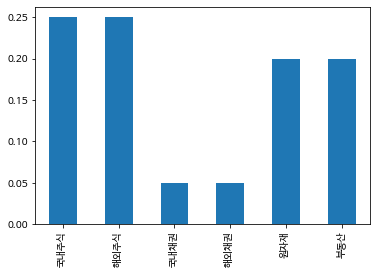

In [ ]:
# 각 자산이 위험 기여도가 목표로 했던 것과 동일
risk_contribution_check = calculate_risk_contribution(risk_budgeting_portfolio, cov_mat)
display(risk_contribution_check)
risk_contribution_check.plot(kind='bar')
plt.show()

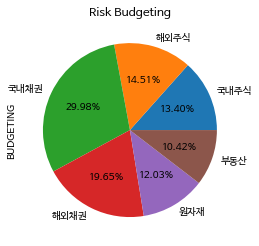

In [ ]:
risk_budgeting_portfolio_df.iloc[0,:6].plot(kind='pie',
                                       title='Risk Budgeting',
                                       autopct='%.2f%%')
plt.show()

In [ ]:
risk_budgeting_portfolio_df = add_columns(risk_budgeting_portfolio_df)
risk_budgeting_portfolio_df

,국내주식,해외주식,국내채권,해외채권,원자재,부동산,비중합,기대수익,실효기대수익,표준편차,샤프비율,Shortfall Risk,VAR,CVAR
BUDGETING,0.1340,0.1451,0.2998,0.1965,0.1203,0.1042,1.0000,0.0643,0.0295,0.1007,0.2927,0.1283,-0.1014,-0.1435
